In [142]:
import pandas as pd

import Create_inputs
import importlib

import xarray as xr
xr.set_options(display_expand_attrs=True, display_width=1000, display_max_rows=1000)

importlib.reload(Create_inputs)

<module 'Create_inputs' from 'c:\\Users\\dias3\\Desktop\\FIRE-HACK\\Notebooks\\5Deployment\\backend\\utils\\Create_inputs.py'>

In [143]:
# inputs da interface

duration = 4

mins_since_fire_start = 0

start_time = pd.to_datetime("2017-10-15 14:20:00")

In [144]:
model_inputs = Create_inputs.Compile_data(duration, mins_since_fire_start, start_time)
print(model_inputs.head())

Existing NetCDF found. Checking for missing time steps...
All requested time steps are already available locally.
Creating spatial mask... this may take a moment


Dataset filtered by spatial mask
     duration_hours  latitude  longitude    sW_100    FWI_12h    wv100_k  \
346               1      42.2       -8.2  0.304889  46.852032  30.285674   
383               1      42.1       -8.6  0.195497  43.426638  30.809326   
384               1      42.1       -8.5  0.237690  43.675119  28.179733   
385               1      42.1       -8.4  0.253234  43.923600  28.821067   
386               1      42.1       -8.3  0.268778  45.719533  29.524706   

        wv_850    Cape    gT_8_7  fuel_load       pct_3_8    pct_8p  fstart  
346  51.492799   4.905  8.386482  18.340001  3.699300e-02  0.958251     0.0  
383  73.469597  10.505  8.396642  13.461379  2.986500e-14  0.705467     0.0  
384  65.970199  11.775  8.420255  13.978603  1.254536e-01  0.132970     0.0  
385  60.423912   8.875  8.445818  12.494936  5.038180e-02  0.128159     0.0  
386  54.883338   5.975  8.471389  12.779295  1.334359e-01  0.233231     0.0  


In [145]:
model_inputs_sorted = model_inputs.sort_values(by='latitude', ascending=True)

# Mostra as primeiras linhas
print(model_inputs_sorted.head())

      duration_hours  latitude  longitude    sW_100    FWI_12h    wv100_k  \
5025               2      37.0       -7.7  0.023655  31.492950  33.268791   
2479               1      37.0       -8.1  0.026020  37.346406  36.757019   
2480               1      37.0       -8.0  0.026038  37.073359  35.872008   
2481               1      37.0       -7.9  0.026020  34.542169  34.669617   
2482               1      37.0       -7.8  0.026001  33.017560  33.579368   

         wv_850     Cape    gT_8_7  fuel_load  pct_3_8  pct_8p  fstart  
5025  19.913237  726.675  8.765801        NaN      NaN     NaN     0.0  
2479  24.536547  753.350  8.795260        NaN      NaN     NaN     0.0  
2480  23.232204  755.500  8.818877        NaN      NaN     NaN     0.0  
2481  22.215263  752.250  8.813337        NaN      NaN     NaN     0.0  
2482  21.203596  749.000  8.807793        NaN      NaN     NaN     0.0  


In [146]:
import pandas as pd
import pickle
import numpy as np

# Carregar o modelo
with open(r'..\..\..\..\Data\Models\XGBoost.pkl', 'rb') as f:
    model = pickle.load(f)

# Mapear nomes atuais para nomes esperados pelo modelo
rename_dict = {
    'duration_hours': 'duration_p',
    'sW_100': 'sW_100_av',
    'pct_8p': '8_ny_fir_p',
    'pct_3_8': '3_8y_fir_p',
    'fuel_load': 'f_load_av',
    'fstart': 'f_start',
    'FWI_12h': 'FWI_12h_av',
    'wv100_k': 'wv100_k_av',
    'wv_850': 'wv_850_av',
    'Cape': 'Cape_av',
    'gT_8_7': 'gT_8_7_av'
}

# Selecionar colunas e renomear
X = model_inputs.drop(columns=['latitude', 'longitude']).rename(columns=rename_dict)

# Verificar se todas as colunas do modelo estão presentes
missing_cols = set(model.get_booster().feature_names) - set(X.columns)
if missing_cols:
    raise ValueError(f"Faltando colunas: {missing_cols}")

# Reordenar as colunas para a ordem esperada pelo modelo
expected_cols = model.get_booster().feature_names
X = X[expected_cols]

# Fazer previsões
predictions = model.predict(X)

# Adicionar previsões ao DataFrame original
model_inputs['predictions'] = predictions


model_inputs['linear_pred'] = np.exp(predictions)


print(model_inputs.head())


     duration_hours  latitude  longitude    sW_100    FWI_12h    wv100_k  \
346               1      42.2       -8.2  0.304889  46.852032  30.285674   
383               1      42.1       -8.6  0.195497  43.426638  30.809326   
384               1      42.1       -8.5  0.237690  43.675119  28.179733   
385               1      42.1       -8.4  0.253234  43.923600  28.821067   
386               1      42.1       -8.3  0.268778  45.719533  29.524706   

        wv_850    Cape    gT_8_7  fuel_load       pct_3_8    pct_8p  fstart  \
346  51.492799   4.905  8.386482  18.340001  3.699300e-02  0.958251     0.0   
383  73.469597  10.505  8.396642  13.461379  2.986500e-14  0.705467     0.0   
384  65.970199  11.775  8.420255  13.978603  1.254536e-01  0.132970     0.0   
385  60.423912   8.875  8.445818  12.494936  5.038180e-02  0.128159     0.0   
386  54.883338   5.975  8.471389  12.779295  1.334359e-01  0.233231     0.0   

     predictions  linear_pred  
346     2.354809    10.536112  
383 

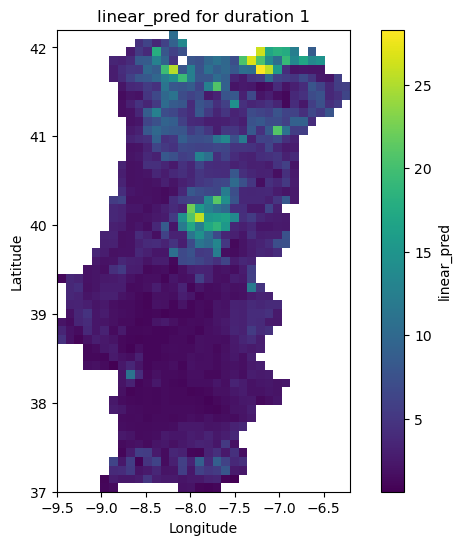

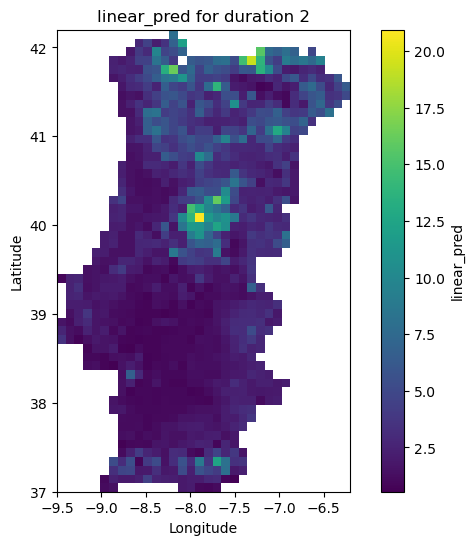

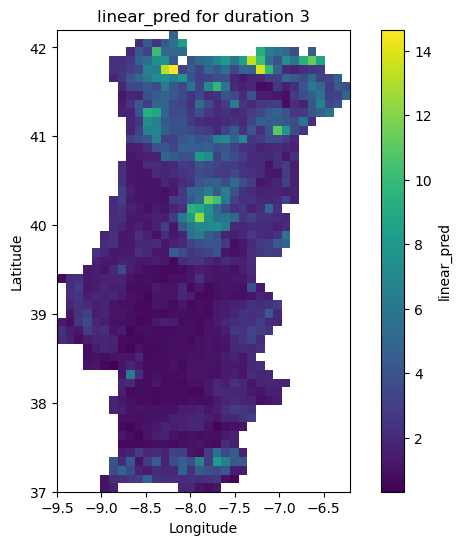

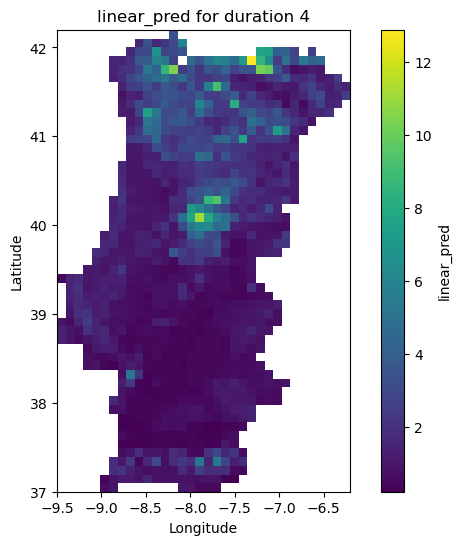

In [147]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# Supondo que model_inputs já contém 'linear_pred', 'latitude', 'longitude', 'duration_hours'

for duration in model_inputs['duration_hours'].unique():
    # Filtrar pelo duration atual
    df = model_inputs[model_inputs['duration_hours'] == duration]

    # Ordenar latitudes e longitudes
    lat_vals = np.sort(df['latitude'].unique())
    lon_vals = np.sort(df['longitude'].unique())

    # Criar matriz 2D para linear_pred
    data_grid = np.full((len(lat_vals), len(lon_vals)), np.nan)

    # Preencher a matriz
    for i, lat in enumerate(lat_vals):
        for j, lon in enumerate(lon_vals):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)]['linear_pred']
            if not val.empty:
                data_grid[i, j] = val.values[0]

    # Criar transform para raster (assumindo grade regular)
    pixel_size_lat = (lat_vals.max() - lat_vals.min()) / (len(lat_vals)-1)
    pixel_size_lon = (lon_vals.max() - lon_vals.min()) / (len(lon_vals)-1)
    transform = from_origin(lon_vals.min()-pixel_size_lon/2, 
                            lat_vals.max()+pixel_size_lat/2, 
                            pixel_size_lon, 
                            pixel_size_lat)

    # Inverter a matriz verticalmente para o TIFF
    data_grid_to_save = np.flipud(data_grid)

    # Salvar TIFF
    output_filename = rf'Data\Output\ros_linear_pred_duration_{duration}.tif'
    with rasterio.open(
        output_filename,
        'w',
        driver='GTiff',
        height=data_grid_to_save.shape[0],
        width=data_grid_to_save.shape[1],
        count=1,
        dtype=data_grid_to_save.dtype,
        crs='EPSG:4326',  # WGS84
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(data_grid_to_save, 1)

    # Plotar (já com latitude crescendo de baixo para cima)
    plt.figure(figsize=(8,6))
    plt.imshow(data_grid, origin='lower',
               extent=(lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()))
    plt.colorbar(label='linear_pred')
    plt.title(f'linear_pred for duration {duration}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
